In [20]:
!pip install numpy
!pip install opencv-python
!pip install ultralytics
!pip install albumentations
!pip install matplotlib
!pip install pandas

In [21]:
from ultralytics import YOLO
import os
import re
import shutil
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from matplotlib import pyplot as plt
import pandas as pd

In [22]:
root_folder = '/Users/alv.popov/prj/DL-CASE1'
data_folder = os.path.join(root_folder, 'data', 'train')
annotations_file = os.path.join(data_folder, 'annotations.txt')
images_folder = os.path.join(data_folder, 'img')

In [34]:
def parse_annotations(file_path):
    content = {
        'filename': [],
        'visibility': [],
        'signType': [],
        'signName': [],
        'lrx': [],
        'lry': [],
        'ulx': [],
        'uly': [],
    }
    with open(file_path, 'r') as f:
        for line in f:
            filename, signs_str = line.strip().split(':')

            for raw_sign in signs_str.split(';')[:-1]:
                if raw_sign == 'MISC_SIGNS' or not raw_sign.strip():
                    continue
                else:
                    visibility, lrx, lry, ulx, uly, signType, signName = raw_sign.split(', ')
                    content['filename'].append(filename)
                    content['visibility'].append(visibility) # насколько хорошо видно знак
                    content['signType'].append(signType) # INFORMATION | MANDATORY | WARNING
                    content['signName'].append(signName) # тип знака
                    content['lrx'].append(lrx) # нижний правый x
                    content['lry'].append(lry) # нижний правый y
                    content['ulx'].append(ulx) # нижний правый x
                    content['uly'].append(uly) # нижний правый y
    return pd.DataFrame(content, index=content['filename'])

signs = parse_annotations('/Users/alv.popov/prj/DL-CASE1/data/train/annotations.txt')
print(len(signs))
signs.head()

588


,filename,visibility,signType,signName,lrx,lry,ulx,uly
1277391792Image000176.jpg,1277391792Image000176.jpg,BLURRED,MANDATORY,PASS_RIGHT_SIDE,477.359139,778.322656,458.781361,761.809076
1277391792Image000176.jpg,1277391792Image000176.jpg,BLURRED,INFORMATION,PRIORITY_ROAD,664.588811,762.915532,654.557700,751.257754
1277384435Image000001.jpg,1277384435Image000001.jpg,VISIBLE,OTHER,OTHER,692.360932,714.811254,652.110932,673.311254
1277391703Image000133.jpg,1277391703Image000133.jpg,VISIBLE,WARNING,GIVE_WAY,885.707826,694.554505,854.427395,665.751732
1277391703Image000133.jpg,1277391703Image000133.jpg,VISIBLE,OTHER,OTHER,887.113503,726.421615,857.065817,695.507169


In [46]:
signs.groupby(['signType']).count()

,filename,visibility,signName,lrx,lry,ulx,uly
signType,,,,,,,
INFORMATION,142,142,142,142,142,142,142
MANDATORY,86,86,86,86,86,86,86
OTHER,96,96,96,96,96,96,96
PROHIBITORY,222,222,222,222,222,222,222
UNREADABLE,1,1,1,1,1,1,1
WARNING,41,41,41,41,41,41,41


In [45]:
signs.groupby(['signName']).count()

,filename,visibility,signType,lrx,lry,ulx,uly
signName,,,,,,,
100_SIGN,15,15,15,15,15,15,15
110_SIGN,25,25,25,25,25,25,25
120_SIGN,24,24,24,24,24,24,24
30_SIGN,9,9,9,9,9,9,9
50_SIGN,44,44,44,44,44,44,44
60_SIGN,11,11,11,11,11,11,11
70_SIGN,40,40,40,40,40,40,40
80_SIGN,20,20,20,20,20,20,20
90_SIGN,4,4,4,4,4,4,4


In [19]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:02<00:00, 2.77MB/s]


In [54]:
images = list(map(lambda x: os.path.join(images_folder, x), signs['filename'][:5].tolist()))
results = model(images, classes=9)
len(results)


0: 480x640 2 traffic lights, 1: 480x640 2 traffic lights, 2: 480x640 (no detections), 3: 480x640 (no detections), 4: 480x640 (no detections), 705.5ms
Speed: 3.4ms preprocess, 141.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


5

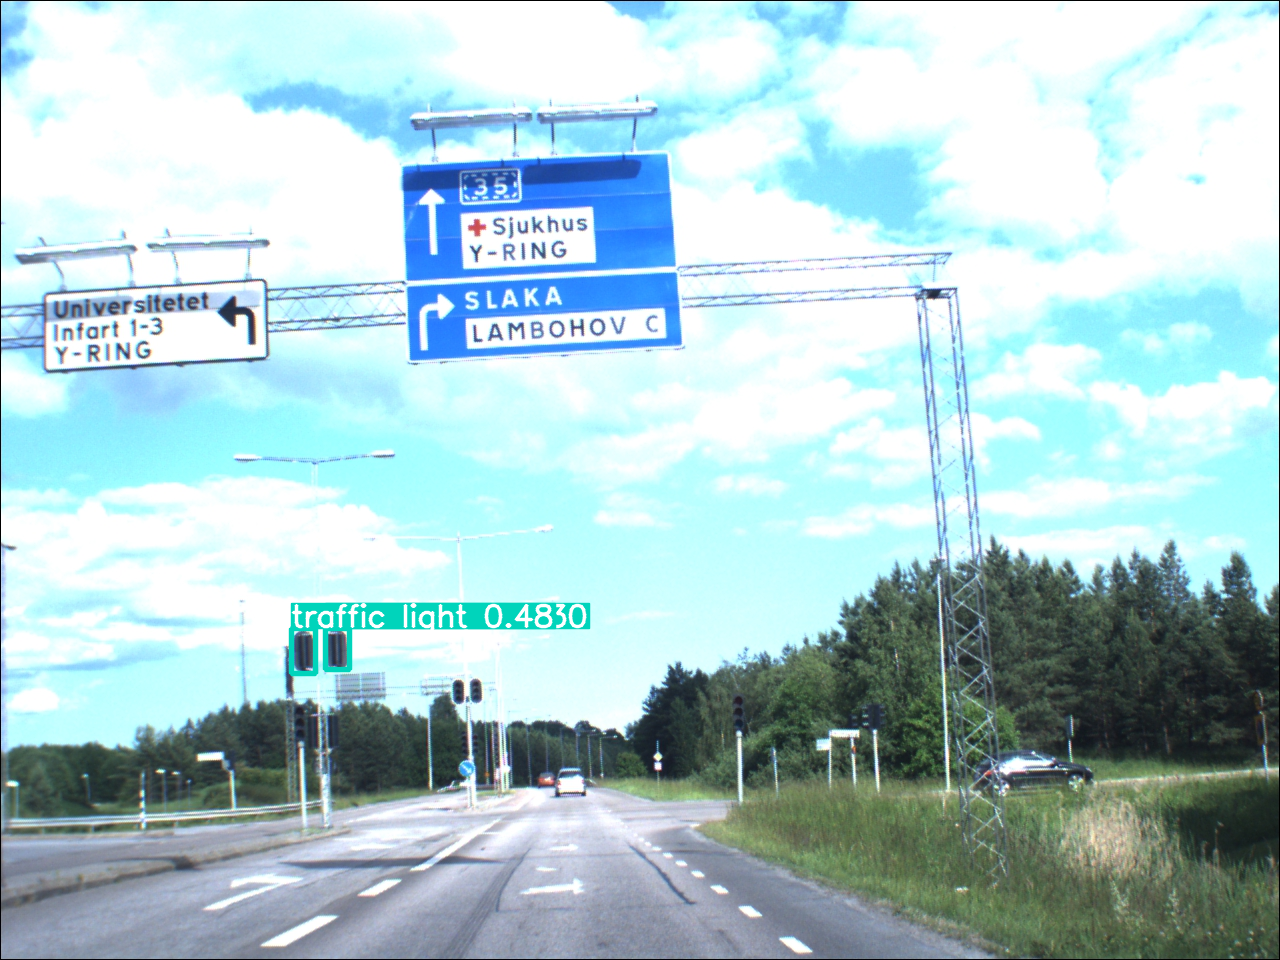

In [55]:
# Show the results
r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)  # show image

In [56]:
r.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([9., 9.])
conf: tensor([0.4769, 0.3013])
data: tensor([[2.9168e+02, 6.2878e+02, 3.1560e+02, 6.7398e+02, 4.7694e-01, 9.0000e+00],
        [3.2586e+02, 6.2818e+02, 3.4932e+02, 6.6904e+02, 3.0133e-01, 9.0000e+00]])
id: None
is_track: False
orig_shape: (960, 1280)
shape: torch.Size([2, 6])
xywh: tensor([[303.6363, 651.3790,  23.9181,  45.2017],
        [337.5919, 648.6121,  23.4569,  40.8657]])
xywhn: tensor([[0.2372, 0.6785, 0.0187, 0.0471],
        [0.2637, 0.6756, 0.0183, 0.0426]])
xyxy: tensor([[291.6772, 628.7782, 315.5953, 673.9799],
        [325.8635, 628.1792, 349.3204, 669.0449]])
xyxyn: tensor([[0.2279, 0.6550, 0.2466, 0.7021],
        [0.2546, 0.6544, 0.2729, 0.6969]])